<a href="https://colab.research.google.com/github/vrublevskiyvitaliy/paraphrase_identification/blob/master/Dependancy_graph_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# All installs here

# Download medium model
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.1MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051305 sha256=a9b143c3554c5633dd1bbb2ec0f90f72190d915bef051eb6bfa09209ee658f93
  Stored in directory: /tmp/pip-ephem-wheel-cache-neg89ls9/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [0]:
# All imports and installs should be here
import os
import sys

import pandas as pd
import numpy as np
from nltk import wordpunct_tokenize
import operator
import re, string
import math
import spacy
import copy

from nltk import Tree
# Space module import
import en_core_web_md
# NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.
import networkx as nx
from networkx import __version__ as nxv
# linear_sum_assignment Hungarian algorithm
from scipy.optimize import linear_sum_assignment

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# Nice progress bars
from tqdm.notebook import tqdm

In [0]:
# All constants

COLAB_ENV = "colab"
LOCAL_ENV = "local"

SENTENCE_START_TOKEN = "sentence_start"
SENTENCE_END_TOKEN = "sentence_end"
UNKNOWN_TOKEN = "unknown_token"


In [0]:
def get_spacy_module():
  return en_core_web_md.load()

In [0]:
# To be able run this notebook from Google Colab and localy

def get_running_env():
  current_path = os.getcwd()
  if current_path == "/content":
    return COLAB_ENV
  return LOCAL_ENV

RUNNING_ENV = get_running_env()

In [0]:
# Supress output of the cell
%%capture
def download_corpus():
    """
      Downloading corpus files for colab research.
    """ 
    if RUNNING_ENV == LOCAL_ENV:
      return
    files = [
      'vrublevskiyvitaliy/paraphrase_identification/contents/dataset/msr-paraphrase-corpus/msr_paraphrase_train.txt',
      'vrublevskiyvitaliy/paraphrase_identification/contents/dataset/msr-paraphrase-corpus/msr_paraphrase_test.txt',
    ]
    for f in files:
       !curl --remote-name \
          -H 'Accept: application/vnd.github.v3.raw' \
          --location https://api.github.com/repos/{f}

download_corpus()

In [0]:
def get_data_location():
  return "" if RUNNING_ENV == COLAB_ENV else "./dataset/msr-paraphrase-corpus/"

def add_start_end_sentence_tokens(s):
  return "%s %s %s" % (SENTENCE_START_TOKEN, s, SENTENCE_END_TOKEN)

def load_data(_preprocess_sentence=None, _train=False, _test=False):
    "Load the MSRP dataset."
    loc = get_data_location()
    trainloc = loc + 'msr_paraphrase_train.txt'
    testloc = loc + 'msr_paraphrase_test.txt'

    if _preprocess_sentence is None:
      _preprocess_sentence = lambda x: x

    sent1_train, sent2_train, sent1_test, sent2_test = [], [], [], []
    label_train, label_dev, label_test = [], [], []

    if _train:
        with open(trainloc, 'r', encoding='utf8') as f:
            f.readline()  # skipping the header of the file
            for line in f:
                text = line.strip().split('\t')
                sent1_train.append(_preprocess_sentence(text[3]))
                sent2_train.append(_preprocess_sentence(text[4]))
                label_train.append(int(text[0]))

    if _test:
        with open(testloc, 'r', encoding='utf8') as f:
            f.readline()  # skipping the header of the file
            for line in f:
                text = line.strip().split('\t')
                sent1_test.append(_preprocess_sentence(text[3]))
                sent2_test.append(_preprocess_sentence(text[4]))
                label_test.append(int(text[0]))

    if _train and _test:
        return [sent1_train, sent2_train], [sent1_test, sent2_test], [label_train, label_test]
    elif _train:
        return [sent1_train, sent2_train], label_train
    elif _test:
        return [sent1_test, sent2_test], label_test

In [0]:
data = load_data(_preprocess_sentence=None, _train=True, _test=False)

In [0]:
def get_sample_data(index=0):
  all_data = load_data(_preprocess_sentence=None, _train=True, _test=False)
  return all_data[0][0][index], all_data[0][1][index], all_data[1][index]

def get_sample(index=0):
  all_data = load_data(_preprocess_sentence=None, _train=True, _test=False)
  return {'s1': all_data[0][0][index], 's2': all_data[0][1][index], 'label': all_data[1][index]}



In [10]:
sample = get_sample_data()
sample

('Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.',
 'Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.',
 1)

In [0]:
nlp = get_spacy_module()

In [12]:
def get_dependancy_graph(s, display=False):
  doc = nlp(s)
  if display:
    spacy.displacy.render(doc, style="dep", jupyter=True)
  edges = []
  nodes = [{
      "node": "ROOT",
      "token": None,
      "is_fake": True, 
  }]
  for token in doc:
    nodes.append({
        "node": token.text,
        "token": token,
        "is_fake": False,
    })
    if token.dep_ == "ROOT":
      edges.append({
        "start": "ROOT",
        "end": token.text,
        "start_node_id": 0,
        "end_node_id": token.i + 1,
        "type": token.dep_
      })
    else:
      edges.append({
        "start": token.head.text,
        "end": token.text,
        "start_node_id":  token.head.i + 1,
        "end_node_id": token.i + 1,
        "type": token.dep_
      })
  return {"nodes": nodes, "edges": edges}

graph1 = get_dependancy_graph(sample[0], False)
graph2 = get_dependancy_graph(sample[1], False)
print(graph1)
print(graph2)

{'nodes': [{'node': 'ROOT', 'token': None, 'is_fake': True}, {'node': 'Amrozi', 'token': Amrozi, 'is_fake': False}, {'node': 'accused', 'token': accused, 'is_fake': False}, {'node': 'his', 'token': his, 'is_fake': False}, {'node': 'brother', 'token': brother, 'is_fake': False}, {'node': ',', 'token': ,, 'is_fake': False}, {'node': 'whom', 'token': whom, 'is_fake': False}, {'node': 'he', 'token': he, 'is_fake': False}, {'node': 'called', 'token': called, 'is_fake': False}, {'node': '"', 'token': ", 'is_fake': False}, {'node': 'the', 'token': the, 'is_fake': False}, {'node': 'witness', 'token': witness, 'is_fake': False}, {'node': '"', 'token': ", 'is_fake': False}, {'node': ',', 'token': ,, 'is_fake': False}, {'node': 'of', 'token': of, 'is_fake': False}, {'node': 'deliberately', 'token': deliberately, 'is_fake': False}, {'node': 'distorting', 'token': distorting, 'is_fake': False}, {'node': 'his', 'token': his, 'is_fake': False}, {'node': 'evidence', 'token': evidence, 'is_fake': False

Here I try to explore diferent Graph similarity algorithms:

First approach
1.   Map nodes using Hungarian algorithm
2.   Count Graph Edit Distance GED also using Hungarian algorithm



Ideas to try:
* add treshold for node matching, only if > 0.5 for example merge nodes

Next ideas to try: 
* From graphs get graph based entities like path, or subgraphs.
* Combine vectors in these entities
* Count # of entities with some similarity threshold


In [0]:
# Code is taken from https://github.com/Jacobe2169/ged4py

class EdgeGraph():
    def __init__(self, init_node, nodes):
        self.init_node=init_node
        self.nodes_ = nodes

    def nodes(self):
        return self.nodes_

    def size(self):
        return len(self.nodes)
    def __len__(self):
        return len(self.nodes_)

class AbstractGraphEditDistance(object):
    def __init__(self, g1, g2):
        self.g1 = g1
        self.g2 = g2

    def normalized_distance(self):
        """
        Returns the graph edit distance between graph g1 & g2
        The distance is normalized on the size of the two graphs.
        This is done to avoid favorisation towards smaller graphs
        """
        avg_graphlen = len(self.g1) + len(self.g2)
        return self.distance() / avg_graphlen

    def distance(self):
        return sum(self.edit_costs())

    def edit_costs(self):
        cost_matrix = self.create_cost_matrix()
        row_ind,col_ind = linear_sum_assignment(cost_matrix)
        return [cost_matrix[row_ind[i]][col_ind[i]] for i in range(len(row_ind))]

    def create_cost_matrix(self):
        """
        Creates a |N+M| X |N+M| cost matrix between all nodes in
        graphs g1 and g2
        Each cost represents the cost of substituting,
        deleting or inserting a node
        The cost matrix consists of four regions:
        substitute 	| insert costs
        -------------------------------
        delete 		| delete -> delete
        The delete -> delete region is filled with zeros
        """
        n = len(self.g1)
        m = len(self.g2)
        cost_matrix = np.zeros((n+m,n+m))
        #cost_matrix = [[0 for i in range(n + m)] for j in range(n + m)]
        nodes1 = self.g1.nodes() if float(nxv) < 2 else list(self.g1.nodes())
        nodes2 = self.g2.nodes() if float(nxv) < 2 else list(self.g2.nodes())

        for i in range(n):
            for j in range(m):
                cost_matrix[i,j] = self.substitute_cost(nodes1[i], nodes2[j])

        for i in range(m):
            for j in range(m):
                cost_matrix[i+n,j] = self.insert_cost(i, j, nodes2)

        for i in range(n):
            for j in range(n):
                cost_matrix[j,i+m] = self.delete_cost(i, j, nodes1)

        self.cost_matrix = cost_matrix
        return cost_matrix

    def insert_cost(self, i, j):
        raise NotImplementedError

    def delete_cost(self, i, j):
        raise NotImplementedError

    def substitute_cost(self, nodes1, nodes2):
        raise NotImplementedError

    def print_matrix(self):
        print("cost matrix:")
        for column in self.create_cost_matrix():
            for row in column:
                if row == sys.maxsize:
                    print ("inf\t")
                else:
                    print ("%.2f\t" % float(row))
            print("")

class EdgeEditDistance(AbstractGraphEditDistance):
    """
    Calculates the graph edit distance between two edges.
    A node in this context is interpreted as a graph,
    and edges are interpreted as nodes.
    """

    def __init__(self, g1, g2):
        AbstractGraphEditDistance.__init__(self, g1, g2)

    def insert_cost(self, i, j, nodes2):
        if i == j:
            return 1
        return sys.maxsize

    def delete_cost(self, i, j, nodes1):
        if i == j:
            return 1
        return sys.maxsize

    def substitute_cost(self, edge1, edge2):
        if edge1 == edge2:
            return 0.
        return 1

class GraphEditDistance(AbstractGraphEditDistance):
    def __init__(self, g1, g2):
        AbstractGraphEditDistance.__init__(self, g1, g2)

    def substitute_cost(self, node1, node2):
        return self.relabel_cost(node1, node2) + self.edge_diff(node1, node2)

    def relabel_cost(self, node1, node2):
        if node1 == node2:
            return 0.
        else:
            return 1.

    def delete_cost(self, i, j, nodes1):
        if i == j:
            return 1
        return sys.maxsize

    def insert_cost(self, i, j, nodes2):
        if i == j:
            return 1
        else:
            return sys.maxsize

    def pos_insdel_weight(self, node):
        return 1

    def edge_diff(self, node1, node2):
        edges1 = list(self.g1.edge[node1].keys()) if float(nxv) < 2 else list(self.g1.edges(node1))
        edges2 = list(self.g2.edge[node2].keys()) if float(nxv) < 2 else list(self.g2.edges(node2))
        if len(edges1) == 0 or len(edges2) == 0:
            return max(len(edges1), len(edges2))

        edit_edit_dist = EdgeEditDistance(EdgeGraph(node1,edges1), EdgeGraph(node2,edges2))
        return edit_edit_dist.normalized_distance()

def compare_graphs(g1, g2, print_details=False, use_normalized=True):
    ged = GraphEditDistance(g1, g2)

    if print_details:
        ged.print_matrix()

    return ged.normalized_distance() if use_normalized else ged.distance()


In [0]:
class HungarianGraphNodesMatcher:

  def __init__(self, _g1, _g2, threshold=0.5):
    self.g1 = _g1
    self.g2 = _g2
    self.node_threshold = threshold
    self.create_cost_matrix()
    self.match_nodes()
    

  def create_cost_matrix(self):
    self.matrix = np.zeros((len(self.g1["nodes"]), len(self.g2["nodes"])))
    for i1, n1 in enumerate(self.g1["nodes"]):
       for i2, n2 in enumerate(self.g2["nodes"]):
         if (not n1["is_fake"] and not n2["is_fake"] and 
            n1["token"].has_vector and n2["token"].has_vector):
           self.matrix[i1][i2] = n1["token"].similarity(n2["token"])
         elif n1["is_fake"] == n2["is_fake"]:
           self.matrix[i1][i2] = n1["node"] == n2["node"]
         else:
           self.matrix[i1][i2] = 0

    # Now we need to fleep scores, because Hungarian is trying to minimize
    self.cost = np.subtract(np.full(self.matrix.shape, 1), self.matrix)

  def get_pandas_matrix(self):
    df = pd.DataFrame(
        data=self.matrix,
        index=np.array([n["node"] for n in self.g1["nodes"]]),
        columns=np.array([n["node"] for n in self.g2["nodes"]])
      )
    
    return df

  def match_nodes(self):
    row_ind, col_ind = linear_sum_assignment(self.cost)

    self.graph1_to_graph2 = {
        item[0]: item[1] 
        for item in zip(row_ind, col_ind)
        if self.matrix[item[0]][item[1]] > self.node_threshold
    }
    self.row_ind = row_ind
    self.col_ind = col_ind

  def create_node_aliases(self):
    for id1, n1 in enumerate(self.g1["nodes"]):
      n1["alias"] = "G1_" + str(id1) + n1["node"]
    for id2, n2 in enumerate(self.g2["nodes"]):
      n2["alias"] = "G2_" + str(id2) + n2["node"] 
    for id1, id2 in self.graph1_to_graph2.items():
      n1 = self.g1["nodes"][id1]
      n2 = self.g2["nodes"][id2]
      n1["alias"] = "G1_" + str(id1) + "_" + n1["node"] + "_G2_" + str(id2) + "_" + n2["node"]
      n2["alias"] = n1["alias"]

  def build_graph(self, g):
    nx_g = nx.Graph()
    for edge1 in g["edges"]:
      start_node = g["nodes"][edge1["start_node_id"]]
      end_node = g["nodes"][edge1["end_node_id"]]
      nx_g.add_edge(start_node["alias"], end_node["alias"])
    return nx_g

  def get_converted_graphs(self):
    self.create_node_aliases()
    g1 = self.build_graph(self.g1)
    g2 = self.build_graph(self.g2)
    return g1, g2

  def print_matched_nodes(self):
    print ("Graph 1  =>   Graph 2")
    for id1, id2 in self.graph1_to_graph2.items():
      print(f"{self.g1['nodes'][id1]['node']}    =>   {self.g2['nodes'][id2]['node']}")

In [0]:
node_matcher = HungarianGraphNodesMatcher(graph1, graph2, 0.9)

In [16]:
node_matcher.print_matched_nodes()
len(node_matcher.graph1_to_graph2)

Graph 1  =>   Graph 2
ROOT    =>   ROOT
Amrozi    =>   Amrozi
accused    =>   accused
his    =>   his
brother    =>   brother
,    =>   ,
"    =>   "
the    =>   the
witness    =>   witness
"    =>   "
of    =>   of
deliberately    =>   deliberately
distorting    =>   distorting
his    =>   his
evidence    =>   evidence
.    =>   .


16

In [17]:
df = node_matcher.get_pandas_matrix()

df

,ROOT,Referring,to,him,as,only,"""",the,witness,"""",",",Amrozi,accused,his,brother,of,deliberately,distorting,his,evidence,.
ROOT,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Amrozi,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
accused,0.0,0.462788,0.247302,0.428843,0.329721,0.288702,0.177370,0.245612,0.495963,0.177370,0.154774,0.0,1.000000,0.409809,0.430317,0.245755,0.492152,0.162321,0.409809,0.455700,0.089694
his,0.0,0.448873,0.450099,0.818316,0.534291,0.459990,0.307721,0.589037,0.460539,0.307721,0.247196,0.0,0.409809,1.000000,0.595102,0.470308,0.375484,0.248710,1.000000,0.372411,0.293258
brother,0.0,0.326865,0.278940,0.593552,0.359954,0.315489,0.165423,0.276650,0.382124,0.165423,0.260554,0.0,0.430317,0.595102,1.000000,0.218296,0.202813,0.091600,0.595102,0.181388,0.244569
",",0.0,0.191477,0.260884,0.260457,0.453440,0.272194,0.225224,0.207785,0.204928,0.225224,1.000000,0.0,0.154774,0.247196,0.260554,0.246289,0.178351,0.115272,0.247196,0.218267,0.421524
whom,0.0,0.530618,0.404365,0.627295,0.527354,0.508026,0.194234,0.375806,0.491248,0.194234,0.233465,0.0,0.503349,0.543793,0.561806,0.362452,0.402099,0.123924,0.543793,0.391814,0.222853
he,0.0,0.501589,0.436620,0.827520,0.592211,0.577246,0.372794,0.491815,0.476299,0.372794,0.350859,0.0,0.454249,0.791888,0.579133,0.374885,0.455827,0.210478,0.791888,0.417391,0.419956
called,0.0,0.503237,0.357370,0.417062,0.558222,0.401485,0.448924,0.532806,0.269240,0.448924,0.206856,0.0,0.313714,0.409235,0.322105,0.401833,0.246508,0.108304,0.409235,0.295163,0.251584
"""",0.0,0.314289,0.299291,0.304552,0.358556,0.277636,1.000000,0.299336,0.192335,1.000000,0.225224,0.0,0.177370,0.307721,0.165423,0.237327,0.202483,0.119719,0.307721,0.209467,0.292410


In [18]:
node_matcher.print_matched_nodes()
g1, g2 = node_matcher.get_converted_graphs()
score = compare_graphs(g1, g2)
print(f"Similarity score {score}")

Graph 1  =>   Graph 2
ROOT    =>   ROOT
Amrozi    =>   Amrozi
accused    =>   accused
his    =>   his
brother    =>   brother
,    =>   ,
"    =>   "
the    =>   the
witness    =>   witness
"    =>   "
of    =>   of
deliberately    =>   deliberately
distorting    =>   distorting
his    =>   his
evidence    =>   evidence
.    =>   .
Similarity score 0.25825292593585275


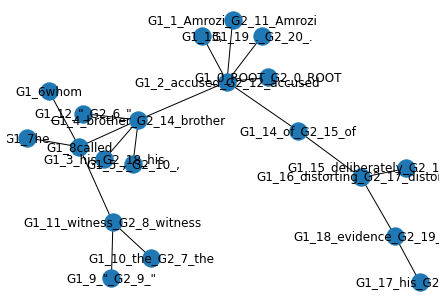

In [19]:
nx.draw(g1, with_labels=True)

In [0]:
def calculate_scores(limit=10):
  result = []
  for i in range(limit):
    s1 = data[0][0][i]
    s2 = data[0][1][i]
    label = data[1][i]
    graph1 = get_dependancy_graph(s1, False)
    graph2 = get_dependancy_graph(s2, False)
    node_matcher = HungarianGraphNodesMatcher(graph1, graph2, 0.8)  
    g1, g2 = node_matcher.get_converted_graphs()
    score = compare_graphs(g1, g2)
    result.append((s1, s2, label, score))
  return result

result = calculate_scores()

In [21]:
for d in result:
  print (f"Label {d[2]}  |   Score {d[3]}")

Label 1  |   Score 0.23386268203341373
Label 0  |   Score 0.42761100687929954
Label 1  |   Score 0.21203703703703702
Label 0  |   Score 0.7764705882352941
Label 1  |   Score 0.7268617021276597
Label 1  |   Score 0.28887310606060607
Label 0  |   Score 0.5682821452052221
Label 1  |   Score 0.19363553113553114
Label 0  |   Score 0.4580687830687831
Label 1  |   Score 0.7452380952380953


In [0]:
prepared_data = {}

def prepare_data(feature_generator, force=False, limit=100000):
  feature_name = feature_generator.NAME
  global prepared_data
  if feature_name not in prepared_data or force:
    all_data = load_data(_preprocess_sentence=None, _train=True, _test=True)
    train_X = [
      feature_generator.get_features(item[0], item[1])
      for index, item in tqdm(enumerate(zip(all_data[0][0][:limit], all_data[0][1][:limit])))
    ]
    train_Y = all_data[2][0][:limit]
    test_X = [
      feature_generator.get_features(item[0], item[1])
      for index, item in tqdm(enumerate(zip(all_data[1][0][:limit], all_data[1][1][:limit])))
    ]
    test_Y = all_data[2][1][:limit]
    features = {}
    features['train_X'] = train_X
    features['train_Y'] = train_Y
    features['test_X'] = test_X
    features['test_Y'] = test_Y
    prepared_data[feature_name] = features

def verbose_data(feature_generator, limit=10):
    all_data = load_data(_preprocess_sentence=None, _train=True, _test=True)
    train_raw_data = [
      {
        's1': item[0],
        's2': item[1],
        'label': item[2]
      }
      for item in zip(all_data[0][0][:limit], all_data[0][1][:limit], all_data[2][0][:limit])
    ]
    for item in train_raw_data:
      features = feature_generator.get_features(item['s1'], item['s2'])
      print(item['s1'])
      print(item['s2'])
      print(f"Label {item['label']}")
      print(features)
      print("*"* 8)

def get_metrics(feature_generator, classificator, force=False, limit=None):
  prepare_data(feature_generator, force, limit)
  global prepared_data
  feature_name = feature_generator.NAME
  classificator.fit(
    prepared_data[feature_name]['train_X'],
    prepared_data[feature_name]['train_Y']
  )

  test_Y_predicted = classificator.predict(prepared_data[feature_name]['test_X'])

  precision = precision_score(
    prepared_data[feature_name]['test_Y'],
    test_Y_predicted
  )
  recall = recall_score(
    prepared_data[feature_name]['test_Y'],
    test_Y_predicted
  )
  f1 = f1_score(
    prepared_data[feature_name]['test_Y'],
    test_Y_predicted
  )
  accuracy = accuracy_score(
    prepared_data[feature_name]['test_Y'],
    test_Y_predicted
  )

  return {
    "precision" : round(precision * 100, 2),
    "recall" : round(recall * 100, 2),
    "f1" : round(f1 * 100, 2),
    "accuracy" : round(accuracy * 100, 2),
  }

class BaselineFeatureGenerator:
  NAME = 'Baseline'

  def get_features(self, s1, s2):
    return np.array([1])

In [30]:
classificator = LogisticRegression()
baseline_feature_generator = BaselineFeatureGenerator()
print("Baseline")
get_metrics(baseline_feature_generator, classificator, True, 100)

Baseline


{'accuracy': 68.0, 'f1': 80.95, 'precision': 68.0, 'recall': 100.0}

In [0]:
class HungarianGraphFeatureGenerator:
  NAME = 'HungarianGraph'

  def get_features(self, s1, s2):
    graph1 = get_dependancy_graph(s1, False)
    graph2 = get_dependancy_graph(s2, False)
    node_matcher = HungarianGraphNodesMatcher(graph1, graph2, 0.9)
    g1, g2 = node_matcher.get_converted_graphs()
    score_normalized = compare_graphs(g1, g2, False, True)
    score_raw = compare_graphs(g1, g2, False, False)
    return np.array([score_normalized, score_raw])

hungarian_feature_generator = HungarianGraphFeatureGenerator()

# It gives {'precision': 73.99, 'recall': 89.54, 'f1': 81.03, 'accuracy': 72.12}
# on LinearSVC()

In [0]:
class HungarianNodeFeatureGenerator:
  NAME = 'HungarianNode'

  def get_features(self, s1, s2):
    graph1 = get_dependancy_graph(s1, False)
    graph2 = get_dependancy_graph(s2, False)
    node_matcher = HungarianGraphNodesMatcher(graph1, graph2, 0.9)
    g1, g2 = node_matcher.get_converted_graphs()
    n1, n2 = len(g1), len(g2)
    num_matched_nodes = len(node_matcher.graph1_to_graph2)
    percent_matched = num_matched_nodes * 2. / (n1 + n2)
    features = np.array([n1, n2, percent_matched])
    return features

hungarian_node_feature_generator = HungarianNodeFeatureGenerator()
# It gives {'precision': 74.5, 'recall': 90.67, 'f1': 81.79, 'accuracy': 73.16}
# on SGDClassifier(),

In [53]:
verbose_data(hungarian_node_feature_generator)


Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.
Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.
Label 1
[20.        21.         0.7804878]
********
Yucaipa owned Dominick's before selling the chain to Safeway in 1998 for $2.5 billion.
Yucaipa bought Dominick's in 1995 for $693 million and sold it to Safeway for $1.8 billion in 1998.
Label 0
[18.         23.          0.58536585]
********
They had published an advertisement on the Internet on June 10, offering the cargo for sale, he added.
On June 10, the ship's owners had published an advertisement on the Internet, offering the explosives for sale.
Label 1
[22.  23.   0.8]
********
Around 0335 GMT, Tab shares were up 19 cents, or 4.4%, at A$4.56, having earlier set a record high of A$4.57.
Tab shares jumped 20 cents, or 4.6%, to set a record closing high at A$4.57.
Label 0
[30.         21.          0.66666667]
********
The stoc

In [0]:
def base_classification_test(feature_generator):
  classificators = [
    SVC(),
    LinearSVC(),
    DecisionTreeClassifier(),
    GaussianNB(),
    Perceptron(),
    SGDClassifier(),
    RandomForestClassifier(),
  ]
  for classificator in classificators:
    score = get_metrics(feature_generator, classificator)
    print(score)

In [56]:
# Uncomment to test
# prepare_data(hungarian_feature_generator, True, 100000)
# base_classification_test(hungarian_feature_generator)


{'precision': 66.69, 'recall': 99.65, 'f1': 79.9, 'accuracy': 66.67}


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'precision': 73.99, 'recall': 89.54, 'f1': 81.03, 'accuracy': 72.12}
{'precision': 73.41, 'recall': 73.67, 'f1': 73.54, 'accuracy': 64.75}
{'precision': 78.04, 'recall': 78.38, 'f1': 78.21, 'accuracy': 70.96}
{'precision': 66.49, 'recall': 100.0, 'f1': 79.87, 'accuracy': 66.49}
{'precision': 66.49, 'recall': 100.0, 'f1': 79.87, 'accuracy': 66.49}
{'precision': 74.86, 'recall': 79.69, 'f1': 77.2, 'accuracy': 68.7}


In [59]:
# Uncomment to test
# prepare_data(hungarian_node_feature_generator, True, 100000)
# base_classification_test(hungarian_node_feature_generator)


{'precision': 66.49, 'recall': 100.0, 'f1': 79.87, 'accuracy': 66.49}
{'precision': 66.49, 'recall': 100.0, 'f1': 79.87, 'accuracy': 66.49}
{'precision': 66.49, 'recall': 100.0, 'f1': 79.87, 'accuracy': 66.49}
{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 33.51}
{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 33.51}
{'precision': 66.49, 'recall': 100.0, 'f1': 79.87, 'accuracy': 66.49}


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:450: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:452: RuntimeWarning: invalid value encountered in true_divide
  (self.sigma_[i, :]), 1)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'precision': 66.49, 'recall': 100.0, 'f1': 79.87, 'accuracy': 66.49}
